In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.manual_seed(123)
device = 'cpu'
torch.set_default_dtype(torch.float64)

Tamanhos: torch.Size([800, 2]) torch.Size([200, 2])


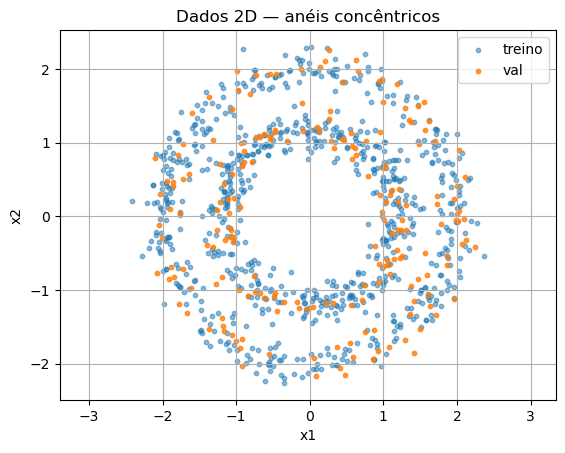

In [3]:
def make_concentric_rings(n_total=1000, r1=1.2, r2=2.0, noise=0.15):
    n = n_total//2
    th1 = 2*math.pi*torch.rand(n)
    th2 = 2*math.pi*torch.rand(n)
    r1s = r1 + noise*torch.randn(n)
    r2s = r2 + noise*torch.randn(n)
    x1 = torch.stack([r1s*torch.cos(th1), r1s*torch.sin(th1)], dim=1)
    x2 = torch.stack([r2s*torch.cos(th2), r2s*torch.sin(th2)], dim=1)
    X = torch.cat([x1,x2], dim=0)
    y = torch.cat([torch.zeros(n), torch.ones(n)], dim=0).unsqueeze(1)
    # embaralha
    idx = torch.randperm(X.size(0))
    return X[idx], y[idx]

X, y = make_concentric_rings(1000)
N = X.size(0)
n_train = int(0.8*N)
X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:], y[n_train:]
print('Tamanhos:', X_train.shape, X_val.shape)

# Visualiza dados
plt.figure()
plt.scatter(X_train[:,0].numpy(), X_train[:,1].numpy(), s=10, alpha=0.5, label='treino')
plt.scatter(X_val[:,0].numpy(),   X_val[:,1].numpy(),   s=10, alpha=0.8, label='val')
plt.title('Dados 2D — anéis concêntricos')
plt.xlabel('x1'); plt.ylabel('x2'); plt.axis('equal'); plt.legend(); plt.grid(True)
plt.show()


In [ ]:
def build_mlp(input_dim=2, hidden=[64,64], dropout=0.0, activation='relu'):
    layers = []
    act = nn.ReLU if activation.lower()=='relu' else nn.Tanh
    prev = input_dim
    for h in hidden:
        layers += [nn.Linear(prev, h), act()]
        if dropout>0: layers += [nn.Dropout(dropout)]
        prev = h
    layers += [nn.Linear(prev, 1)]  # saída logit (BCEWithLogitsLoss)
    return nn.Sequential(*layers)

def accuracy_from_logits(logits, y_true):
    pred = (torch.sigmoid(logits) >= 0.5).double()
    return (pred.eq(y_true).double().mean()).item()

def train_model(Xtr, ytr, Xva, yva, *, hidden=[64,64], lr=1e-2, batch_size=64,
                epochs=200, optimizer='adam', dropout=0.0, weight_decay=0.0, activation='relu'):
    model = build_mlp(2, hidden, dropout, activation).to(device)
    ds = TensorDataset(Xtr.to(device), ytr.to(device))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)
    crit = nn.BCEWithLogitsLoss()
    if optimizer.lower()=='sgd':
         opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    hist = {'loss_tr': [], 'acc_tr': [], 'acc_va': []}
    for ep in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in dl:
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()*xb.size(0)
        epoch_loss /= len(ds)

        model.eval()
        with torch.no_grad():
            acc_tr = accuracy_from_logits(model(Xtr), ytr)
            acc_va = accuracy_from_logits(model(Xva), yva)
        hist['loss_tr'].append(epoch_loss); hist['acc_tr'].append(acc_tr); hist['acc_va'].append(acc_va)

    return model, hist

In [ ]:
configs = [
    dict(name='A: SGD lr=0.1',     optimizer='sgd',  lr=0.1,  hidden=[32],     dropout=0.0, batch_size=64),
    dict(name='B: SGD lr=0.01',    optimizer='sgd',  lr=0.01, hidden=[32],     dropout=0.0, batch_size=64),
    dict(name='C: SGD lr=0.01 dp', optimizer='sgd',  lr=0.01, hidden=[64,64],  dropout=0.2, batch_size=64),
    dict(name='D: Adam lr=0.01',   optimizer='adam', lr=0.01, hidden=[64,64],  dropout=0.0, batch_size=64),
    dict(name='E: Adam lr=0.001',  optimizer='adam', lr=0.001,hidden=[64,64],  dropout=0.0, batch_size=64),
    dict(name='F: Adam wd=1e-4',   optimizer='adam', lr=0.001,hidden=[64,64],  dropout=0.2, batch_size=64, weight_decay=1e-4),
    dict(name='G: Adam wide',      optimizer='adam', lr=0.001,hidden=[128,128],dropout=0.2, batch_size=64),
    dict(name='H: Adam small bs',  optimizer='adam', lr=0.001,hidden=[64,64],  dropout=0.0, batch_size=16),
]

results = []
histories = {}
best = None
for cfg in configs:
    model, hist = train_model(X_train, y_train, X_val, y_val,
                              hidden=cfg.get('hidden',[64,64]), lr=cfg.get('lr',1e-3),
                              batch_size=cfg.get('batch_size',64), epochs=200,
                              optimizer=cfg.get('optimizer','adam'), dropout=cfg.get('dropout',0.0),
                              weight_decay=cfg.get('weight_decay',0.0))
    acc_va = hist['acc_va'][-1]
    acc_tr = hist['acc_tr'][-1]
    results.append({**cfg, 'acc_val': acc_va, 'acc_train': acc_tr})
    histories[cfg['name']] = hist
    if best is None or acc_va > best['acc_val']:
        best = {**cfg, 'model': model, 'hist': hist, 'acc_val': acc_va}

df = pd.DataFrame(results)
df_sorted = df.sort_values('acc_val', ascending=False).reset_index(drop=True)
df_sorted

In [ ]:
top3 = df_sorted.head(3)['name'].tolist()
for name in top3:
    h = histories[name]
    plt.figure()
    plt.plot(h['loss_tr'], label='loss treino')
    plt.plot(h['acc_tr'], label='acc treino')
    plt.plot(h['acc_va'], label='acc val')
    plt.title(f'Aprendizado — {name}')
    plt.xlabel('época'); plt.grid(True); plt.legend(); plt.show()

In [ ]:
best_name = df_sorted.iloc[0]['name']
best_model = best['model']
xmin, ymin = X.min(0).values - 0.5
xmax, ymax = X.max(0).values + 0.5
xx, yy = torch.meshgrid(torch.linspace(xmin, xmax, 300), torch.linspace(ymin, ymax, 300), indexing='xy')
grid = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)
with torch.no_grad():
    zz = torch.sigmoid(best_model(grid)).reshape_as(xx)

plt.figure()
plt.contourf(xx.numpy(), yy.numpy(), zz.numpy(), levels=20)
plt.scatter(X_val[:,0].numpy(), X_val[:,1].numpy(), s=10, c=y_val.squeeze().numpy())
plt.title(f'Fronteira de decisão — {best_name}')
plt.xlabel('x1'); plt.ylabel('x2'); plt.axis('equal'); plt.grid(True)
plt.show()


In [ ]:
your_cfg = dict(hidden=[64,64], lr=5e-3, batch_size=64, epochs=200,
                optimizer='adam', dropout=0.1, weight_decay=0.0)
model, hist = train_model(X_train, y_train, X_val, y_val, **your_cfg)
plt.figure(); plt.plot(hist['acc_va']); plt.title('Sua execução — acc val'); plt.xlabel('época'); plt.grid(True); plt.show()


In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.manual_seed(123)
device = 'cpu'
torch.set_default_dtype(torch.float64)

Tamanhos: torch.Size([800, 2]) torch.Size([200, 2])


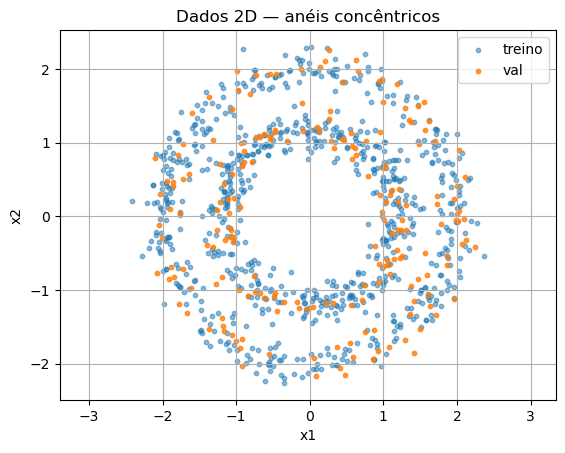

In [2]:
def make_concentric_rings(n_total=1000, r1=1.2, r2=2.0, noise=0.15):
    n = n_total//2
    th1 = 2*math.pi*torch.rand(n)
    th2 = 2*math.pi*torch.rand(n)
    r1s = r1 + noise*torch.randn(n)
    r2s = r2 + noise*torch.randn(n)
    x1 = torch.stack([r1s*torch.cos(th1), r1s*torch.sin(th1)], dim=1)
    x2 = torch.stack([r2s*torch.cos(th2), r2s*torch.sin(th2)], dim=1)
    X = torch.cat([x1,x2], dim=0)
    y = torch.cat([torch.zeros(n), torch.ones(n)], dim=0).unsqueeze(1)
    # embaralha
    idx = torch.randperm(X.size(0))
    return X[idx], y[idx]

X, y = make_concentric_rings(1000)
N = X.size(0)
n_train = int(0.8*N)
X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:], y[n_train:]
print('Tamanhos:', X_train.shape, X_val.shape)


# Visualiza dados
plt.figure()
plt.scatter(X_train[:,0].numpy(), X_train[:,1].numpy(), s=10, alpha=0.5, label='treino')
plt.scatter(X_val[:,0].numpy(),   X_val[:,1].numpy(),   s=10, alpha=0.8, label='val')
plt.title('Dados 2D — anéis concêntricos')
plt.xlabel('x1'); plt.ylabel('x2'); plt.axis('equal'); plt.legend(); plt.grid(True)
plt.show()

In [4]:
def build_mlp(input_dim=2, hidden=[64,64], dropout=0.0, activation='relu'):
    layers = []
    act = nn.ReLU if activation.lower()=='relu' else nn.Tanh
    prev = input_dim
    for h in hidden:
        layers += [nn.Linear(prev, h), act()]
        if dropout>0: layers += [nn.Dropout(dropout)]
        prev = h
    layers += [nn.Linear(prev, 1)]  # saída logit (BCEWithLogitsLoss)
    return nn.Sequential(*layers)

def accuracy_from_logits(logits, y_true):
    pred = (torch.sigmoid(logits) >= 0.5).double()
    return (pred.eq(y_true).double().mean()).item()

def train_model(Xtr, ytr, Xva, yva, *, hidden=[64,64], lr=1e-2, batch_size=64,
                epochs=200, optimizer='adam', dropout=0.0, weight_decay=0.0, activation='relu'):
    model = build_mlp(2, hidden, dropout, activation).to(device)
    ds = TensorDataset(Xtr.to(device), ytr.to(device))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)
    crit = nn.BCEWithLogitsLoss()
    if optimizer.lower()=='sgd':
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    hist = {'loss_tr': [], 'acc_tr': [], 'acc_va': []}
    for ep in range(epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in dl:
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()*xb.size(0)
        epoch_loss /= len(ds)


        model.eval()
        with torch.no_grad():
            acc_tr = accuracy_from_logits(model(Xtr), ytr)
            acc_va = accuracy_from_logits(model(Xva), yva)
        hist['loss_tr'].append(epoch_loss); hist['acc_tr'].append(acc_tr); hist['acc_va'].append(acc_va)

    return model, hist
configs = [
    dict(name='A: SGD lr=0.1',     optimizer='sgd',  lr=0.1,  hidden=[32],     dropout=0.0, batch_size=64),
    dict(name='B: SGD lr=0.01',    optimizer='sgd',  lr=0.01, hidden=[32],     dropout=0.0, batch_size=64),
    dict(name='C: SGD lr=0.01 dp', optimizer='sgd',  lr=0.01, hidden=[64,64],  dropout=0.2, batch_size=64),
    dict(name='D: Adam lr=0.01',   optimizer='adam', lr=0.01, hidden=[64,64],  dropout=0.0, batch_size=64),
    dict(name='E: Adam lr=0.001',  optimizer='adam', lr=0.001,hidden=[64,64],  dropout=0.0, batch_size=64),
    dict(name='F: Adam wd=1e-4',   optimizer='adam', lr=0.001,hidden=[64,64],  dropout=0.2, batch_size=64, weight_decay=1e-4),
    dict(name='G: Adam wide',      optimizer='adam', lr=0.001,hidden=[128,128],dropout=0.2, batch_size=64),
    dict(name='H: Adam small bs',  optimizer='adam', lr=0.001,hidden=[64,64],  dropout=0.0, batch_size=16),
]


results = []
histories = {}
best = None
for cfg in configs:
    model, hist = train_model(X_train, y_train, X_val, y_val,
                              hidden=cfg.get('hidden',[64,64]), lr=cfg.get('lr',1e-3),
                              batch_size=cfg.get('batch_size',64), epochs=200,
                              optimizer=cfg.get('optimizer','adam'), dropout=cfg.get('dropout',0.0),
                              weight_decay=cfg.get('weight_decay',0.0))
    acc_va = hist['acc_va'][-1]
    acc_tr = hist['acc_tr'][-1]
    results.append({**cfg, 'acc_val': acc_va, 'acc_train': acc_tr})
    histories[cfg['name']] = hist
    if best is None or acc_va > best['acc_val']:
        best = {**cfg, 'model': model, 'hist': hist, 'acc_val': acc_va}

df = pd.DataFrame(results)
df_sorted = df.sort_values('acc_val', ascending=False).reset_index(drop=True)
df_sorted


,name,optimizer,lr,hidden,dropout,batch_size,acc_val,acc_train,weight_decay
0,A: SGD lr=0.1,sgd,0.100,[32],0.0,64,1.000,0.99875,NaN
1,B: SGD lr=0.01,sgd,0.010,[32],0.0,64,1.000,0.99875,NaN
2,C: SGD lr=0.01 dp,sgd,0.010,"[64, 64]",0.2,64,1.000,0.99875,NaN
3,E: Adam lr=0.001,adam,0.001,"[64, 64]",0.0,64,1.000,0.99875,NaN
4,F: Adam wd=1e-4,adam,0.001,"[64, 64]",0.2,64,1.000,1.00000,0.0001
5,D: Adam lr=0.01,adam,0.010,"[64, 64]",0.0,64,0.995,0.99875,NaN
6,G: Adam wide,adam,0.001,"[128, 128]",0.2,64,0.995,0.99875,NaN
7,H: Adam small bs,adam,0.001,"[64, 64]",0.0,16,0.995,1.00000,NaN


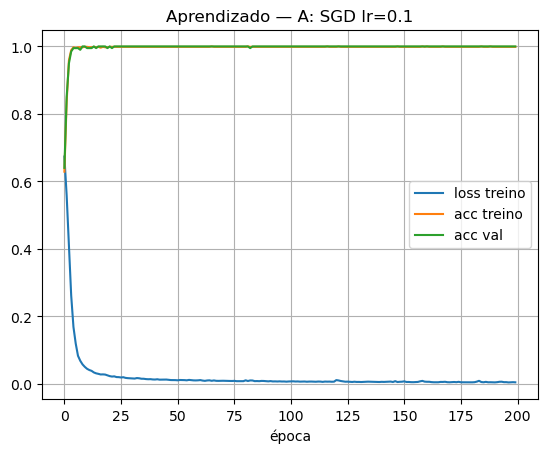

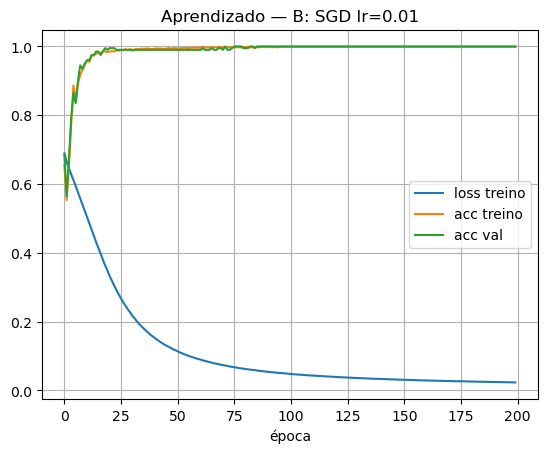

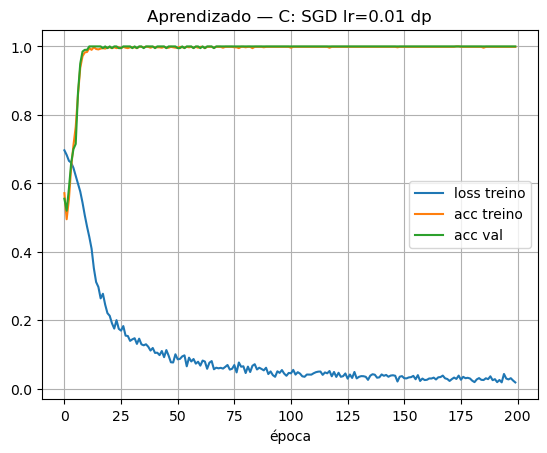

In [5]:
top3 = df_sorted.head(3)['name'].tolist()
for name in top3:
    h = histories[name]
    plt.figure()
    plt.plot(h['loss_tr'], label='loss treino')
    plt.plot(h['acc_tr'], label='acc treino')
    plt.plot(h['acc_va'], label='acc val')
    plt.title(f'Aprendizado — {name}')
    plt.xlabel('época'); plt.grid(True); plt.legend(); plt.show()


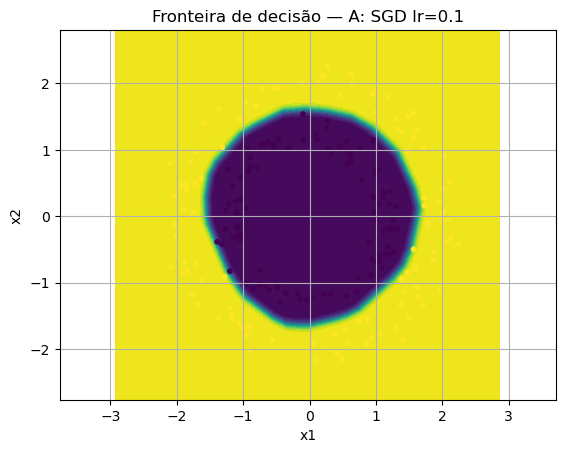

In [6]:
best_name = df_sorted.iloc[0]['name']
best_model = best['model']
xmin, ymin = X.min(0).values - 0.5
xmax, ymax = X.max(0).values + 0.5
xx, yy = torch.meshgrid(torch.linspace(xmin, xmax, 300), torch.linspace(ymin, ymax, 300), indexing='xy')
grid = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)
with torch.no_grad():
    zz = torch.sigmoid(best_model(grid)).reshape_as(xx)

plt.figure()
plt.contourf(xx.numpy(), yy.numpy(), zz.numpy(), levels=20)
plt.scatter(X_val[:,0].numpy(), X_val[:,1].numpy(), s=10, c=y_val.squeeze().numpy())
plt.title(f'Fronteira de decisão — {best_name}')
plt.xlabel('x1'); plt.ylabel('x2'); plt.axis('equal'); plt.grid(True)
plt.show()


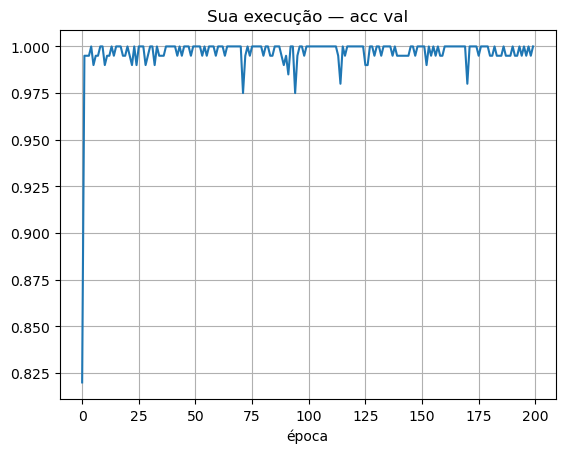

In [7]:
your_cfg = dict(hidden=[64,64], lr=5e-3, batch_size=64, epochs=200,
                optimizer='adam', dropout=0.1, weight_decay=0.0)
model, hist = train_model(X_train, y_train, X_val, y_val, **your_cfg)
plt.figure(); plt.plot(hist['acc_va']); plt.title('Sua execução — acc val'); plt.xlabel('época'); plt.grid(True); plt.show()
